# Single analyser of Model1 on single image using iNNvestigate

## Circular shapes with same radius

This notebook shows how saliency maps are computed for a single method on the Shape Images dataset.

(It is based on the **iNNvestigate** notebook: [Introduciton](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/introduction.ipynb))

## Imports

In [7]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")

from CNNcount import shape_images as si
from CNNcount import model_count_shapes as mcs

#import pixiedust

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data
Load the dataset and keep some images from the test set for the analysis.

The file containing images of the same shape (circle) with same radius already exist!
Size of training data:  (42000, 64, 64, 1) and labels:  (42000,)
Size of test data:  (6000, 64, 64, 1) and labels:  (6000,)


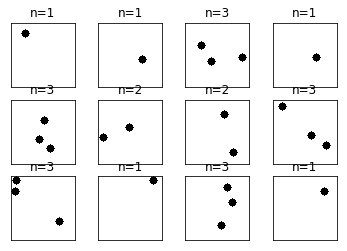

In [8]:
# filename for loading the data from the NPZ files (NumPy compressed)
dataset = 'circles_same_radius'
same_shape_same_radius_fname = "/home/elena/eStep/XAI/Data/CountingShapes/" + dataset + "_60k.npz"

# input image dimensions and number of classes
img_rows, img_cols = 64, 64
num_classes = 3

# load the set of images with the same type and same radius and split to train and test subsets
if os.path.isfile(same_shape_same_radius_fname): # already generated- just load
    print ("The file containing images of the same shape (circle) with same radius already exist!")
    # load from NPZ file for display
    images_train, _, images_test, labels_train, _, labels_test = si.load_split_data(same_shape_same_radius_fname)
    
    
    if K.image_data_format() == 'channels_first':
        images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
        images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)

    print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
    print("Size of test data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))
else: # missing data
    print ("The file containing images of the same shape (circle) with same radius does not exist!")
    print("Use the GenerateShapeImages notebook to generate the experimental data.") 
    
# plot random 12 of the train images
si.plot_12images(images_train, labels_train)

## Model
The next part evaluates the pretrained CNN.

In [9]:
# imports
from CNNcount import model_count_shapes as mcs
# filename for model saving
same_shape_same_radius_model_fname = "/home/elena/eStep/XAI/Data/CountingShapes/model_circles_same_radius.h5"
# load the trained model
from keras.models import load_model
model = load_model(same_shape_same_radius_model_fname) 
print("Loaded model from disk")

Loaded model from disk


Formatting of the labels

In [10]:
# convert class vectors to binary class matrices
numerical_labels_test = labels_test
labels_test = np_utils.to_categorical(numerical_labels_test-1, num_classes=None)
print(labels_test)
print('labels_test shape:', labels_test.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
labels_test shape: (6000, 3)


## Analysis

Chose a random test image to generate a heatmap for.

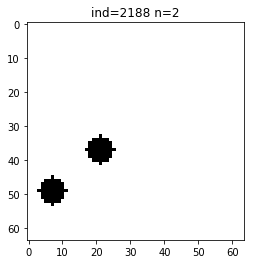

In [11]:
nim = len(labels_test)
ind=int(np.random.randint(1,nim))
img=images_test[ind,:,:]
img=np.reshape(img,(64,64))
label=numerical_labels_test[ind]
plt.imshow(img,cmap='binary')
plt.title('ind=%d n=%d' % (ind,label))
plt.show()

## Choosing the class

Show the output in respect to the all classes.

Analyzer exists. Loading...
Analysis w.r.t. to class 1


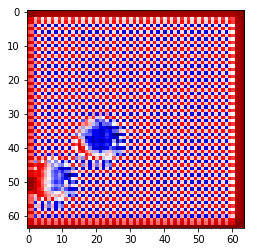

Analysis w.r.t. to class 2


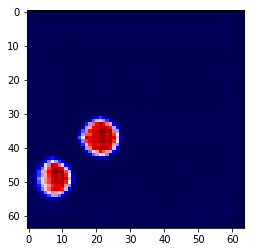

Analysis w.r.t. to class 3


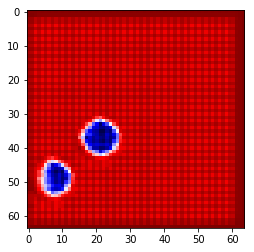

In [12]:
#%%pixie_debugger

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

image = img[np.newaxis, :, :, np.newaxis].astype(np.float32)

# Creating another attribution analyzer and set neuron_selection_mode to "index"
#path to saved analyzers
path_to_analyzers = "/home/elena/eStep/XAI/Data/CountingShapes/Analyzers/" + dataset 
fname = os.path.join(path_to_analyzers, 'pattern.net.npz')

PatternNet_analyzer = innvestigate.create_analyzer("pattern.net", model_wo_sm, pattern_type = "relu", neuron_selection_mode="index")

if os.path.isfile(fname):
    print("Analyzer exists. Loading...")
    PatternNet_analyzer = PatternNet_analyzer.load_npz(fname)
else:
    print("Analyzer doesn't exist. Training and [Saving]...")
    # Some analyzers require training.
    PatternNet_analyzer.fit(images_train, batch_size=200, verbose=1)
    PatternNet_analyzer.save_npz(fname)
    
for neuron_index in range(num_classes):
    print("Analysis w.r.t. to class", neuron_index+1)
    # Applying the analyzer and pass that we want 
    analysis = PatternNet_analyzer.analyze(image, neuron_index)
    
    # Displaying the gradient
    plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
    plt.show()